In [100]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score, RocCurveDisplay

In [3]:
rna_sim=pd.read_csv('rna_similarity.txt',sep='\t')
prot_sim=pd.read_csv('prot_similarity.txt',sep='\t')
inter=pd.read_csv('list_of_interactions.txt',sep='\t')

rna_cnt=inter['RNA_ID'].unique().shape[0] # m
prot_cnt=inter['PROT_ID'].unique().shape[0] # n

In [4]:
Sl=np.empty((rna_cnt,rna_cnt))
Sp=np.empty((prot_cnt,prot_cnt))

In [5]:
Y=np.zeros((rna_cnt,prot_cnt))
for i in inter.index:
    Y[inter['RNA_ID'][i]][inter['PROT_ID'][i]]=1
print(Y)

[[1. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [6]:
for i in rna_sim.index:
    Sl[rna_sim['RNA(i)'][i]][rna_sim['RNA(j)'][i]]=rna_sim['Sim(i,j)'][i]

for i in prot_sim.index:
    Sp[prot_sim['PROT(i)'][i]][prot_sim['PROT(j)'][i]]=prot_sim['Sim(i,j)'][i]


In [7]:
print(Sl)
print(Sl.shape)

[[1.         0.0160874  0.0150442  ... 0.0213873  0.0237827  0.0301653 ]
 [0.0160874  1.         0.0176763  ... 0.0137041  0.00932855 0.0119166 ]
 [0.0150442  0.0176763  1.         ... 0.0161504  0.0089185  0.0141593 ]
 ...
 [0.0213873  0.0137041  0.0161504  ... 1.         0.00932855 0.016763  ]
 [0.0237827  0.00932855 0.0089185  ... 0.00932855 1.         0.00768836]
 [0.0301653  0.0119166  0.0141593  ... 0.016763   0.00768836 1.        ]]
(990, 990)


In [8]:
print(Sp)
print(Sp.shape)

[[1.         0.0114943  0.0199646  ... 0.0132024  0.0103043  0.0126176 ]
 [0.0114943  1.         0.0154265  ... 0.0111918  0.0101835  0.0238959 ]
 [0.0199646  0.0154265  1.         ... 0.0206388  0.0667203  0.0097399 ]
 ...
 [0.0132024  0.0111918  0.0206388  ... 1.         0.0189189  0.0097399 ]
 [0.0103043  0.0101835  0.0667203  ... 0.0189189  1.         0.00951854]
 [0.0126176  0.0238959  0.0097399  ... 0.0097399  0.00951854 1.        ]]
(64, 64)


In [9]:
def construct_neighbourhood(S,M,K,cnt):
    for i in range(cnt):
        ser=pd.Series(S[i])
        ser.sort_values(ascending=False, inplace=True)
        for iter_cnt, j in enumerate(ser.index):
            if iter_cnt>K:
                break
            if j==i:
                continue
            M[i][j]=ser[j]

K1=5
K2=5

A=np.zeros((rna_cnt,rna_cnt))
B=np.zeros((prot_cnt,prot_cnt))

construct_neighbourhood(Sl,A,K1,rna_cnt)
construct_neighbourhood(Sp,B,K1,prot_cnt)


In [10]:
# construction of Ll
Dl=np.zeros((rna_cnt,rna_cnt))
Dl_=np.zeros((rna_cnt,rna_cnt))

for i in range(rna_cnt):
    Dl[i][i]=np.sum(A[i])
    Dl_[i][i]=np.sum(A[:,i])

Ll=Dl+Dl_-(A+A.transpose())

In [11]:
# construction of Lp
Dp=np.zeros((prot_cnt,prot_cnt))
Dp_=np.zeros((prot_cnt,prot_cnt))

for i in range(prot_cnt):
    Dp[i][i]=np.sum(B[i])
    Dp_[i][i]=np.sum(B[:,i])
    
Lp=Dp+Dp_-(B+B.transpose())

In [12]:
print(Ll)

[[0.6680213 0.        0.        ... 0.        0.        0.       ]
 [0.        0.1620434 0.        ... 0.        0.        0.       ]
 [0.        0.        0.2327686 ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.2216763 0.        0.       ]
 [0.        0.        0.        ... 0.        0.3944053 0.       ]
 [0.        0.        0.        ... 0.        0.        0.3830409]]


In [13]:
print(Lp)

[[ 1.2330499   0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.37877098  0.         ...  0.          0.
  -0.0238959 ]
 [ 0.          0.          4.8011551  ...  0.         -0.0667203
   0.        ]
 ...
 [ 0.          0.          0.         ...  1.1811      0.
   0.        ]
 [ 0.          0.         -0.0667203  ...  0.          0.6090052
   0.        ]
 [ 0.         -0.0238959   0.         ...  0.          0.
   0.2156013 ]]


In [14]:
def prob(U,V):
    temp=np.exp(np.matmul(U,V.transpose()))
    return temp/(1+temp)

# P=prob(U,V)
# print(P)

In [15]:
def dL_dU(P,U,V,c,Y,Ll,Lambda_l,alpha,rna_cnt):
    return np.matmul(P,V)+np.matmul(np.multiply(Y,P),V)*(c-1)-np.matmul(Y,V)*c+np.matmul((Lambda_l*np.identity(rna_cnt)+alpha*Ll),U)

def dL_dV(P,U,V,c,Y,Lp,Lambda_p,beta,prot_cnt):
    return np.matmul(P.transpose(),U)+np.matmul(np.multiply(Y.transpose(),P.transpose()),U)*(c-1)-np.matmul(Y.transpose(),U)*c+np.matmul((Lambda_p*np.identity(prot_cnt)+beta*Lp),V)


In [16]:
def grad_des(U,V,Y,c,Ll,Lp,Lambda_l,Lambda_p,alpha,beta,gamma,rna_cnt,prot_cnt,max_iter):
    phi_l=np.zeros((rna_cnt,r))
    phi_p=np.zeros((prot_cnt,r))
    iter_cnt=1
    cont=True
    while(cont):
        P=prob(U,V)
        prev_U=U.copy()
        prev_V=V.copy()
        
        Gl=dL_dU(P,U,V,c,Y,Ll,Lambda_l,alpha,rna_cnt)
        phi_l=phi_l+np.multiply(Gl,Gl)
        U=U-gamma*(Gl/np.sqrt(phi_l))

        Gp=dL_dV(P,U,V,c,Y,Lp,Lambda_p,beta,prot_cnt)
        phi_p=phi_p+np.multiply(Gp,Gp)
        V=V-gamma*(Gp/np.sqrt(phi_p))
        
        # print(f'Iteration[{iter_cnt}]: ',end='')
        iter_cnt+=1
        # print(V[0])
        
        cont=False
        for i in range(rna_cnt):
            if(np.linalg.norm(U[i]-prev_U[i], ord=1)>1e-3):
                cont=True
                break
        
        for i in range(prot_cnt):
            if(np.linalg.norm(V[i]-prev_V[i], ord=1)>1e-3):
                cont=True
                break
    return U,V


In [17]:
def curve_smoothening(vec,sim,neg_set,K2,cnt,r):
    for i in range(cnt):
        if i in neg_set:
            ser=pd.Series(sim[i])
            ser.sort_values(ascending=False, inplace=True)
            num=np.zeros(r)
            den=0
            nbr_cnt=0
            for j in ser.index:
                if j in neg_set:
                    continue
                num+=sim[i][j]*vec[j]
                den+=sim[i][j]
                nbr_cnt+=1
                if(nbr_cnt>=K2):
                    break
            num/=den
            for k in range(r):
                vec[i][k]=num[k]
    return vec


In [120]:
max_iter=1000

In [121]:
r=20
phi_l=np.zeros((rna_cnt,r))
phi_p=np.zeros((prot_cnt,r))

In [122]:
Lambda_l=2
Lambda_p=2

sd=1/math.sqrt(r)

In [123]:
U=np.random.normal(0,sd,(rna_cnt,r))
V=np.random.normal(0,sd,(prot_cnt,r))
# P=prob(U,V)
# print(P)

In [124]:
c=5
alpha=1
beta=1
gamma=0.01
# U,V=grad_des(U,V,Y,c,Ll,Lp,Lambda_l,Lambda_p,alpha,beta,gamma,rna_cnt,prot_cnt,max_iter)

In [69]:
# test_set=np.random.randint(low=0, high=990, size=5)

737
[0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1, 2, 4, 6, 18, 24, 31]


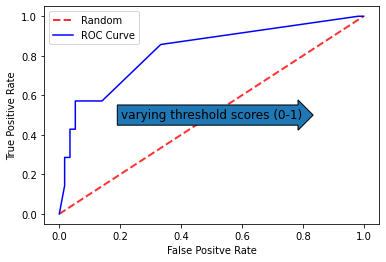

937
[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1, 4]


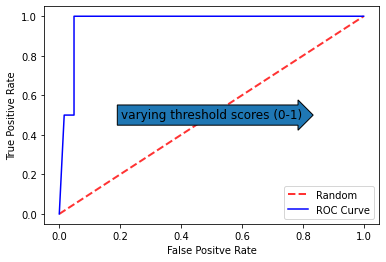

563
[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1, 4, 7, 18]


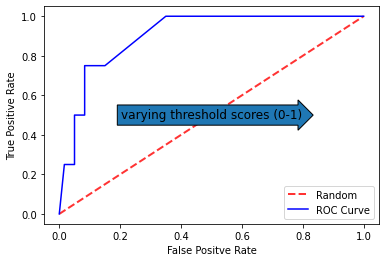

347
[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1, 4]


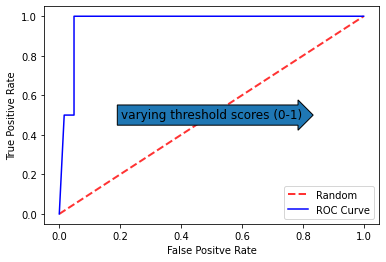

515
[1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0, 1, 4]


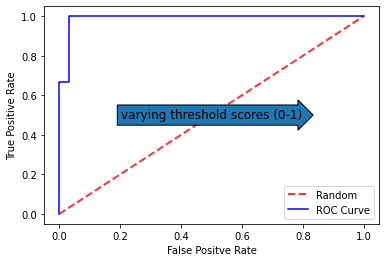

In [70]:
# for n in test_set:
#     neg_rna_set=[]
#     neg_prot_set=[]
#     #n=np.random.randint(0,989)
#     #n=704
#     print(n)
#     print(Y[n])
#     true_positives=[i for i in range(prot_cnt) if Y[n][i]==1]
#     true_negatives=[i for i in range(prot_cnt) if Y[n][i]==0]
#     print(true_positives)
#     neg_rna_set.append(n)
#     modified_Y=Y.copy()
#     for i in range(prot_cnt):
#         modified_Y[n][i]=0
#     U=np.random.normal(0,sd,(rna_cnt,r))
#     V=np.random.normal(0,sd,(prot_cnt,r))
#     U,V=grad_des(U,V,modified_Y,c,Ll,Lp,Lambda_l,Lambda_p,alpha,beta,gamma,rna_cnt,prot_cnt,max_iter)
#     U=curve_smoothening(U,Sl,neg_rna_set,K2,rna_cnt,r)
#     V=curve_smoothening(V,Sp,neg_prot_set,K2,prot_cnt,r)
#     thresholds = np.linspace(0,1,100)
#     tpr=[]
#     fpr=[]
#     pos=len(true_positives)
#     fal=len(true_negatives)
#     for th in thresholds:
#         tp=0
#         fp=0
#         for i in range(64):
#             if pred[i]<th:
#                 break
#             if i in true_positives:
#                 tp+=1
#             else:
#                 fp+=1
#         tpr.append(tp/pos)
#         fpr.append(fp/fal)
#     plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)
#     plt.plot(fpr,tpr, label="ROC Curve",color="blue")
#     plt.text(0.5, 0.5, "varying threshold scores (0-1)", rotation=0, size=12,ha="center", va="center",bbox=dict(boxstyle="rarrow"))
#     plt.xlabel("False Positve Rate")
#     plt.ylabel("True Positive Rate")
#     plt.legend()
#     plt.show()

In [131]:
neg_rna_set=[]
neg_prot_set=[]
n=np.random.randint(0,rna_cnt-1)
# n=704
print(n)
print(Y[n])
true_positives=[i for i in range(prot_cnt) if Y[n][i]==1]
true_negatives=[i for i in range(prot_cnt) if Y[n][i]==0]
print(true_positives)
neg_rna_set.append(n)
modified_Y=Y.copy()
for i in range(prot_cnt):
    modified_Y[n][i]=0

404
[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1, 4, 14, 30, 36, 39, 43]


In [132]:
U,V=grad_des(U,V,modified_Y,c,Ll,Lp,Lambda_l,Lambda_p,alpha,beta,gamma,rna_cnt,prot_cnt,max_iter)

In [133]:
U=curve_smoothening(U,Sl,neg_rna_set,K2,rna_cnt,r)
V=curve_smoothening(V,Sp,neg_prot_set,K2,prot_cnt,r)

In [134]:
P=prob(U,V)
ser=pd.Series(P[n])
ser.sort_values(ascending=False, inplace=True)
for i in ser.index:
    print(i," ",ser[i])
pred=[]
for i in ser.index:
    pred.append((i,ser[i]))
print(pred)

4   0.9807861361899436
1   0.9793292823900225
6   0.7114463477144336
0   0.30957192395164324
15   0.14603797677432848
7   0.14146692548058298
18   0.09807927841645621
13   0.08401039067230574
14   0.057579891959906995
2   0.056598919306232766
34   0.05314117551792966
10   0.05150229856394644
24   0.05051054649675378
35   0.04103908555024362
22   0.03803750790891936
28   0.03717346454003827
51   0.035645140317340146
11   0.03429635862094236
16   0.03321182574870149
30   0.02984644930731762
46   0.029289663430476662
12   0.026508339009672414
36   0.0245313410062255
26   0.02282244978179497
37   0.022555883475210294
39   0.02124889588430508
40   0.01958318620438594
3   0.019155093170609393
27   0.019082053684738687
45   0.016504542075503257
20   0.01616353934391833
17   0.01588090735518345
29   0.015705845354897274
31   0.013947660146449865
53   0.013732377116008615
25   0.013482781415894816
61   0.013170183828743087
33   0.013022629374106589
23   0.012978881261463762
56   0.0129227241196

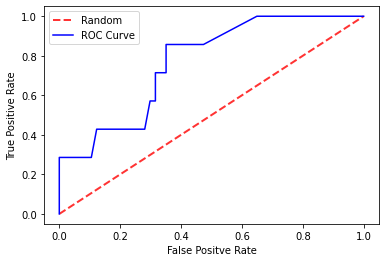

0.7593984962406015


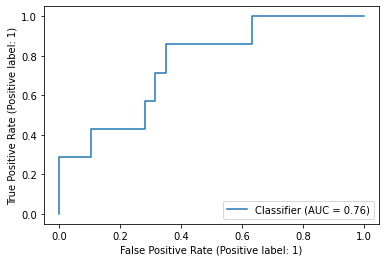

In [138]:
thresholds = np.linspace(0,1,500)
tpr=[]
fpr=[]
pos=len(true_positives)
fal=len(true_negatives)
for th in thresholds:
    tp=0
    fp=0
    for i in range(prot_cnt):
        if pred[i][1]<th:
            break
        if pred[i][0] in true_positives:
            tp+=1
        else:
            fp+=1
    tpr.append(tp/pos)
    fpr.append(fp/fal)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Random', alpha=.8)
plt.plot(fpr,tpr, label="ROC Curve",color="blue")
# plt.text(0.5, 0.5, "varying threshold scores (0-1)", rotation=0, size=12,ha="center", va="center",bbox=dict(boxstyle="rarrow"))
plt.xlabel("False Positve Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



y_pred=P[n]
y_true=np.zeros(prot_cnt)
for yes in true_positives:
    y_true[yes]=1

auc=roc_auc_score(y_true, y_pred)
RocCurveDisplay.from_predictions(y_true,y_pred)

print(auc)

In [136]:
f=open('NRLMF_results.csv','a')
f.write('"'+str(neg_rna_set)+'","'+str(true_positives)+'",'+str(c)+','+str(K1)+','+str(K2)+','+str(Lambda_l)+','+str(Lambda_p)+','+str(alpha)+','+str(beta)+','+str(gamma)+','+str(auc)+'\n')
f.close()